# Lotka-Volterra Equations

The Lotka-Volterra predator-prey equations is a set of ordinary differential equations that can cycle at equilibrium. The equations can take the form:

$\frac{dN}{dt} = rN - \frac{\alpha}{A} N P$

$\frac{dP}{dt} = \frac{\alpha \varepsilon}{A} N P - \delta P $

The prey population is *N*, which increases based on a growth rate (*r*) and decreases depending on predator (*P*) consumption.  The consumption rate comprises of an attack coefficient ($\alpha$, area per predator per time) and the area (*A*) of the system. Area is included to compare with spatial event-based models (Donalson &  Nisbet 1999). The predator population increases by converting consumed prey into offspring controlled with a conversion efficiency ($\varepsilon$) and decreases by a death rate ($\delta$). 

The first part of this notebook solves the Lotka-Volterra predator-prey ODE with a given set of parameters. The second part of this notebook builds the predator-prey model as an IEBM with the same parameters and compares with the ODE results.

In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from multiprocessing import Pool
from tqdm.auto import tqdm

# import datatime to set threads to 1
# allows for better multiprocessing
import datatable as dt
dt.options.nthreads = 1

# set nice plotting style
plt.style.use('bmh')

## Parameters
Set parameters that are used in both the ODE and IEBM. Values selected to have small populations for faster simulations.

In [2]:
r = 0.1 # prey growth rate
a = 1 # predator attack rate
c = 1 # predator conversion efficiency
d = 0.1 # predator death rate
# size of environment
xdim = 50
ydim = 50
A = xdim * ydim
init_prey = 200 # starting prey population size
init_pred = 200 # starting predator population size

# set the simulation time to certain number of cycles
num_cycles = 5
time = 1 / (np.sqrt(r * d) / (2 * np.pi)) * num_cycles
ode_step = 200
ode_times = np.linspace(0, time, ode_step) # inference times

# for the IEBM, individuals need explicit size
prey_radius = 1
pred_radius = 1

## ODE
Solve and visaulize the ODE for the given parameters

In [3]:
# create exponential growth equation as a function of N
def dN_dt(N, t=0):
    return np.array([r*N[0] - a/A*N[0]*N[1],
                     a/A*c*N[0]*N[1] - d*N[1]])

# integrate predator-prey equation
X, info = integrate.odeint(dN_dt, [init_prey, init_pred], ode_times, full_output=True)
# format and store results
ode_prey = X[:, 0]
ode_pred = X[:, 1] 

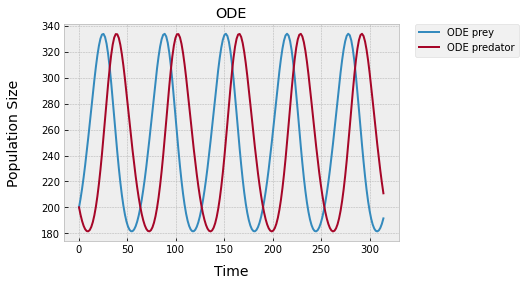

In [4]:
fig, ax = plt.subplots()
ax.plot(ode_times, ode_prey, label='ODE prey')
ax.plot(ode_times, ode_pred, label='ODE predator')
ax.set_title('ODE')
ax.set_ylabel('Population Size', labelpad=20, fontsize=14)
ax.set_xlabel('Time', labelpad=10, fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
plt.show()

## IEBM

Going to create two subtly different predator-prey IEBMs. The first model simulates movement in the predator and prey populations. The prey move aimlessly and it's a waste of computation time. The second model simulates movement in the predator population only, keeping the prey population sessile. Donalson & Nisbet (1999) show how to convert the attack coefficient to a velocity that depends on the size of the individuals and the area of the system.

In [5]:
# point path to IEBM files
import sys
sys.path.append('../../')
# model population in 2-dimensions
from iebm.populations.population2D import Population2D
# import Trait classes to set up Events
from iebm.traits.static_trait import StaticTrait
from iebm.traits.linked_trait import LinkedTrait
# import BirthEvent for the prey
from iebm.events.birth import BirthEvent
# import DeathEvent for the predator
from iebm.events.death import DeathEvent
# movement is simulated by time to boundary (wall) events
from iebm.events.wall import WallEvent
# import 2D interaction for 2D populations
from iebm.events.interact2d import Interact2DEvent
# import class to simulate model
from iebm.simulation import Simulation

In [6]:
# several lotka-volterra IEBMs are tested. the differences between the simulations
# are in the predator and prey traits and events; the model is run the same way.
# this function runs a simulation (given the population, traits, and events) to
# not repeat code throughout the notebook
def lv_model(prey, pred, trait_prey, event_prey, trait_pred, event_pred, progress_bar=True):
        
    # add trait and events to populations
    prey.add_traits(trait_prey)
    prey.add_events(event_prey)
    pred.add_traits(trait_pred)
    pred.add_events(event_pred)
    
    # add event triggers to finish setting up system
    # when new prey is born, check and create new predation collisions
    prey.event_dict['birth'].triggers = pred.event_dict['predation'].set_other_next
    # set the trigger for a predation interaction event
    # a few things occur at a predation event, so we need a function
    def predation_trigger(params):
        events = []
        other_params = params.copy()
        other_params['actor_id'] = other_params['extra']
        # the prey is removed
        events += prey.event_dict['death'].handle(other_params)
        # the predator can give birth
        events += pred.event_dict['birth'].handle(params)
        return events
    pred.event_dict['predation'].triggers = predation_trigger
    # set triggers to calculate new interactions after wall collision
    if 'wall' in prey.event_dict:
        prey.event_dict['wall'].triggers = pred.event_dict['predation'].set_other_next
    if 'wall' in pred.event_dict:
        pred.event_dict['wall'].triggers = pred.event_dict['predation'].set_next
    
    # add the pops to a dictionary 
    pop_dict = {str(prey) : prey, 
                str(pred) : pred}

    # create the simulation with the population dictionary
    sim = Simulation(pop_dict)
    # run simulation
    sim.run(time, progress_bar)
    # return simulation resuls
    return sim.get_results()

### Ideal Gases
In this first model, both the predator and prey move and interact like ideal gases following the law of mass action.

In [7]:
# start with two blank populations
prey = Population2D(name='prey', init_size=init_prey, xdim=xdim, ydim=ydim)
pred = Population2D(name='pred', init_size=init_pred, xdim=xdim, ydim=ydim)

# from Donalson & Nisbet (1999), if both populations move at the same speed, 
# the relative velocity to get the same dynamics as the attack coefficient is:
vel = a * np.pi / (8 * (prey_radius + pred_radius))

# the prey population needs 4 traits
# 1. birth_rate: the 'r' in the ODE and static
# 2. radius: the size of the individual for collisions
# 3. predation_radius: the interaction distance and linked to the radius. 
#    the predation_radius is equal to the radius, so interaction occur on
#    collision.
# 4. velocity is the static value calculated just above
trait_prey = [(StaticTrait, {'name' : 'birth_rate', 
                             'value' : r}), 
              (StaticTrait, {'name' : 'radius', 
                             'value' : prey_radius}),
              (LinkedTrait, {'name' : 'predation_radius', 
                             'link_trait' : 'radius', 
                             'link_func' : lambda x : x}),
              (StaticTrait, {'name' : 'velocity', 
                             'value' : vel})]

# the prey population needs 3 events to correspond with the traits
# 1. BirthEvent: primary event that stores pre-caluclated times that prey
#    individuals give birth. this basic event, offspring are randomly placed
# 2. WallEvent: handles the collision of individuals with the boundary. a 
#    primary event that needs to pre-calculate and store the collision times
# 3. DeathEvent: event to handle predation. a secondary event triggered 
#    when predator and prey individuals interact
event_prey = [(BirthEvent, {'name' : 'birth' , 
                            'is_primary' : True,
                            'current_time' : 0}), 
              (WallEvent, {'name' : 'wall', 
                           'is_primary' : True,
                           'bounce' : 'random',
                           'current_time' : 0}),
              (DeathEvent, {'name' : 'death', 
                            'is_primary' : False, 
                            'current_time' : 0})]

# the predator population has very similar traits as the prey population.
# the only difference is the birth_rate is replaced with a death_rate.
trait_pred = [(StaticTrait, {'name' : 'radius', 
                             'value' : pred_radius}), 
              (LinkedTrait, {'name' : 'predation_radius', 
                             'link_trait' : 'radius', 
                             'link_func' : lambda x: x}),
              (StaticTrait, {'name' : 'velocity', 
                             'value' : vel}),
              (StaticTrait, {'name' : 'death_rate', 
                             'value' : d})]

# the predator population has 4 events that associate with their traits.
# 1. DeathEvent: primary event that pre-calculates and stores when an 
#    individual predator dies.
# 2. WallEvent: primary event to handle wall collisions
# 3. InteractEvent: primary events that pre-calculates predator interaction
#    with prey and triggers secondary events.
# 4. BirthEvent: a secondary event that spawns an offspring of a predator 
#    after a predation event
event_pred = [(DeathEvent, {'name' : 'death',
                            'is_primary' : True,
                            'current_time' : 0}), 
              (WallEvent, {'name' : 'wall', 
                           'is_primary' : True, 
                           'current_time' : 0, 
                           'bounce' : 'random'}), 
              (Interact2DEvent, {'name' : 'predation',
                                 'is_primary' : True,
                                 'current_time'  : 0, 
                                 'other' : prey}), 
              (BirthEvent, {'name' : 'birth', 
                            'is_primary' : False, 
                            'current_time' : 0})]

In [8]:
%%time
# pass predator and prey population along with traits and events to model function
res_ig = lv_model(prey, pred, trait_prey, event_prey, trait_pred, event_pred)


CPU times: user 42.3 s, sys: 5.05 s, total: 47.3 s
Wall time: 41.5 s


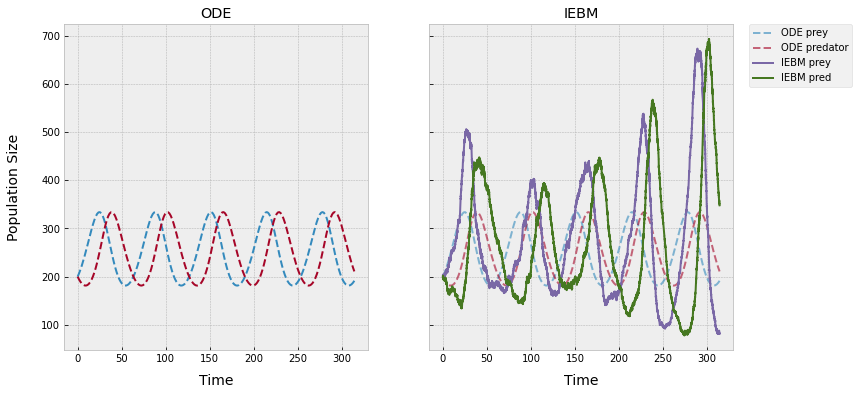

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax[0].plot(ode_times, ode_prey, label='ODE prey', ls='--')
ax[0].plot(ode_times, ode_pred, label='ODE predator', ls='--')
ax[0].set_title('ODE')
ax[0].set_ylabel('Population Size', labelpad=20, fontsize=14)
ax[0].set_xlabel('Time', labelpad=10, fontsize=14)

ax[1].plot(ode_times, ode_prey, label='ODE prey', ls='--', alpha=0.6)
ax[1].plot(ode_times, ode_pred, label='ODE predator', ls='--', alpha=0.6)
for p in res_ig['size']:
    ax[1].plot(res_ig['time'], res_ig['size'][p], label=f'IEBM {p}')
ax[1].set_title('IEBM')
ax[1].set_xlabel('Time', labelpad=10, fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.show()

### Stationary Prey
In the basic Lotka-Volterra model, prey are moving with no purpose and it's a waste of computation time. When the prey are kept stationary, there are less computations and faster simulations. A function is created to setup the model and run the simulation. The function is run multiple times in parallel. With enough runs, the mean population sizes converge towards the ODE dynamics.

#### Single Run

In [10]:
def run_stationary_iebm(progress_bar=False):
    
    # new velocity based on attack rate when one population is stationary
    vel = a / (2 * (prey_radius + pred_radius))
    
    # the rest is nearly exactly as the ideal gas example, with the expection
    # of no WallEvent in the prey
    
    prey = Population2D(name='prey', init_size=init_prey, xdim=xdim, ydim=ydim)
    pred = Population2D(name='pred', init_size=init_pred, xdim=xdim, ydim=ydim)

    trait_prey = [(StaticTrait, {'name' : 'birth_rate', 
                                 'value' : r}), 
                  (StaticTrait, {'name' : 'radius', 
                                 'value' : prey_radius}),
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x : x})]

    event_prey = [(BirthEvent, {'name' : 'birth' , 
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (DeathEvent, {'name' : 'death', 
                                'is_primary' : False, 
                                'current_time' : 0})]
    
    trait_pred = [(StaticTrait, {'name' : 'radius', 
                                 'value' : pred_radius}), 
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x}),
                  (StaticTrait, {'name' : 'velocity', 
                                 'value' : vel}),
                  (StaticTrait, {'name' : 'death_rate', 
                                 'value' : d})]

    event_pred = [(DeathEvent, {'name' : 'death',
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (WallEvent, {'name' : 'wall', 
                               'is_primary' : True, 
                               'current_time' : 0, 
                               'bounce' : 'random'}), 
                  (Interact2DEvent, {'name' : 'predation',
                                     'is_primary' : True,
                                     'current_time'  : 0, 
                                     'other' : prey}), 
                  (BirthEvent, {'name' : 'birth', 
                                'is_primary' : False, 
                                'current_time' : 0})]
    
    return lv_model(prey, pred, trait_prey, event_prey, trait_pred, event_pred, 
                    progress_bar=progress_bar)

In [11]:
%%time
res_stationary = run_stationary_iebm(progress_bar=True)


CPU times: user 28.9 s, sys: 3.7 s, total: 32.6 s
Wall time: 28.4 s


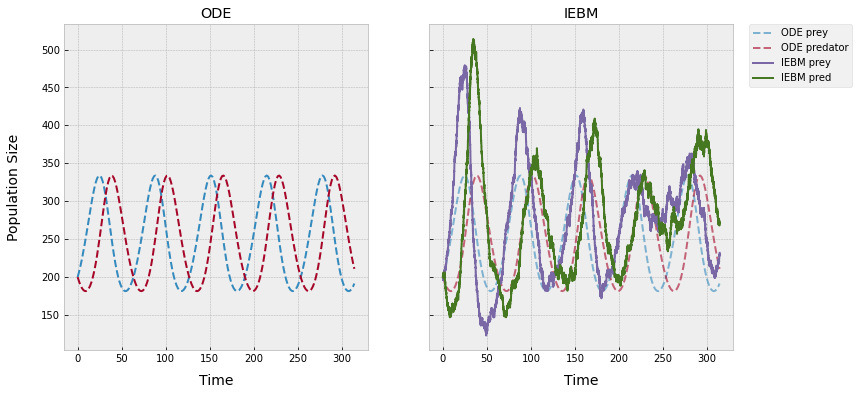

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax[0].plot(ode_times, ode_prey, label='ODE prey', ls='--')
ax[0].plot(ode_times, ode_pred, label='ODE predator', ls='--')
ax[0].set_title('ODE')
ax[0].set_ylabel('Population Size', labelpad=20, fontsize=14)
ax[0].set_xlabel('Time', labelpad=10, fontsize=14)

ax[1].plot(ode_times, ode_prey, label='ODE prey', ls='--', alpha=0.6)
ax[1].plot(ode_times, ode_pred, label='ODE predator', ls='--', alpha=0.6)
for p in res_stationary['size']:
    ax[1].plot(res_stationary['time'], res_stationary['size'][p], label=f'IEBM {p}')
ax[1].set_title('IEBM')
ax[1].set_xlabel('Time', labelpad=10, fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.show()

#### Parallel Run
Multiple runs of the same IEBM can converge to the ODE dynamics. 

In [13]:
runs = 8 #99

pbar = tqdm(total=runs)

res = []
def update(a):
    res.append(a)
    pbar.update()

pool = Pool()

for _ in range(runs):
    pool.apply_async(run_stationary_iebm, 
                     callback=update)

pool.close()
pool.join()
pbar.close()

In [15]:
all_df = []
for rs in res:
    df = {'time' : rs['time']}
    for p in rs['size']:
        df[str(p)] = rs['size'][p]
    df = dt.Frame(df)
    all_df.append(df)
all_df = dt.rbind(df)

In [21]:
all_df['time_int'] = all_df[:, dt.int64(dt.f.time)]
#all_df_grp = all_df[:, (dt.mean(dt.f.prey), dt.mean(dt.f.pred)), dt.by(dt.f.time_int)]
all_df_grp = all_df[:, (dt.median(dt.f.prey), dt.median(dt.f.pred)), dt.by(dt.f.time_int)]

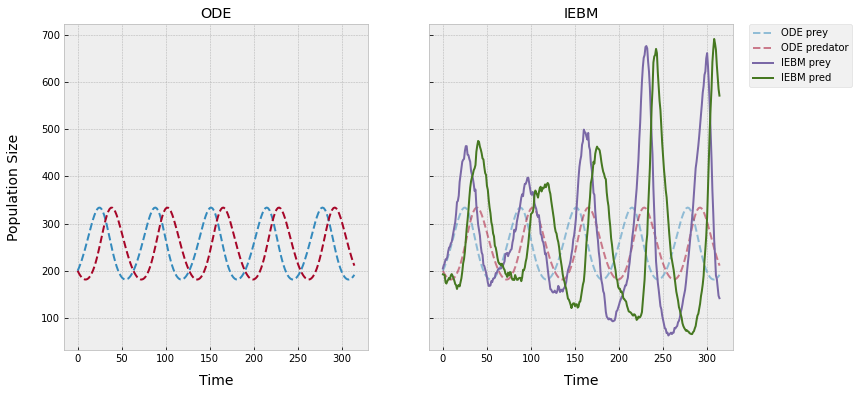

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax[0].plot(ode_times, ode_prey, label='ODE prey', ls='--')
ax[0].plot(ode_times, ode_pred, label='ODE predator', ls='--')
ax[0].set_title('ODE')
ax[0].set_ylabel('Population Size', labelpad=20, fontsize=14)
ax[0].set_xlabel('Time', labelpad=10, fontsize=14)

ax[1].plot(ode_times, ode_prey, label='ODE prey', ls='--', alpha=0.5)
ax[1].plot(ode_times, ode_pred, label='ODE predator', ls='--', alpha=0.5)
columns = [x for x in all_df_grp.names if x!='time_int']
for p in columns:
    ax[1].plot(all_df_grp['time_int'].to_numpy(column=0), all_df_grp[p].to_numpy(column=0), label=f'IEBM {p}')
ax[1].set_title('IEBM')
ax[1].set_xlabel('Time', labelpad=10, fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.show()

### Non-Random Birth Positions
One assumption of the law of mass action is that particles are well-mixed. We can relax this assumption by placing offspring near their neighbour, instead of randomly in the environment, and test the changes in dynamics. The only change from the above examples is the use of the *BirthDiffusionEvent* subclass to keep prey offspring near their parents. Overlaps are allowed to maintain exponential growth in the prey population, like above.

In [23]:
# import new BirthDiffusionEvent
from iebm.events.birth import BirthDiffusionEvent

In [24]:
# create function to run separate non-random birth lotka-loterra births
def run_stationary_diffusion_iebm(odm_factors, progress_bar):
    
    vel = a / (2 * (prey_radius + pred_radius))
    
    prey = Population2D(name='prey', init_size=init_prey, xdim=xdim, ydim=ydim)
    pred = Population2D(name='pred', init_size=init_pred, xdim=xdim, ydim=ydim)

    trait_prey = [(StaticTrait, {'name' : 'birth_rate', 
                                 'value' : r}), 
                  (StaticTrait, {'name' : 'radius', 
                                 'value' : prey_radius}),
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x : x}), 
                  (LinkedTrait, {'name' : 'offspring_dist_max', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x : x * odm_factors})]

    event_prey = [(BirthDiffusionEvent, {'name' : 'birth' , 
                                         'is_primary' : True,
                                         'allow_overlap' : True,
                                         'current_time' : 0}), 
                  (DeathEvent, {'name' : 'death', 
                                'is_primary' : False, 
                                'current_time' : 0})]
    
    trait_pred = [(StaticTrait, {'name' : 'radius', 
                                 'value' : pred_radius}), 
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x}),
                  (StaticTrait, {'name' : 'velocity', 
                                 'value' : vel}),
                  (StaticTrait, {'name' : 'death_rate', 
                                 'value' : d})]

    event_pred = [(DeathEvent, {'name' : 'death',
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (WallEvent, {'name' : 'wall', 
                               'is_primary' : True, 
                               'current_time' : 0, 
                               'bounce' : 'random'}), 
                  (Interact2DEvent, {'name' : 'predation',
                                   'is_primary' : True,
                                   'current_time'  : 0, 
                                   'other' : prey}), 
                  (BirthEvent, {'name' : 'birth', 
                                'is_primary' : False, 
                                'current_time' : 0})]
    
    return lv_model(prey, pred, trait_prey, event_prey, trait_pred, event_pred, progress_bar)

In [27]:
%%time
# run and store results
res_station_diff = run_stationary_diffusion_iebm(4, progress_bar=True)
patchy_times = res_station_diff['time']
patchy_prey = res_station_diff['size']['prey']
patchy_pred = res_station_diff['size']['pred']


CPU times: user 36min 40s, sys: 59.8 s, total: 37min 40s
Wall time: 36min 6s


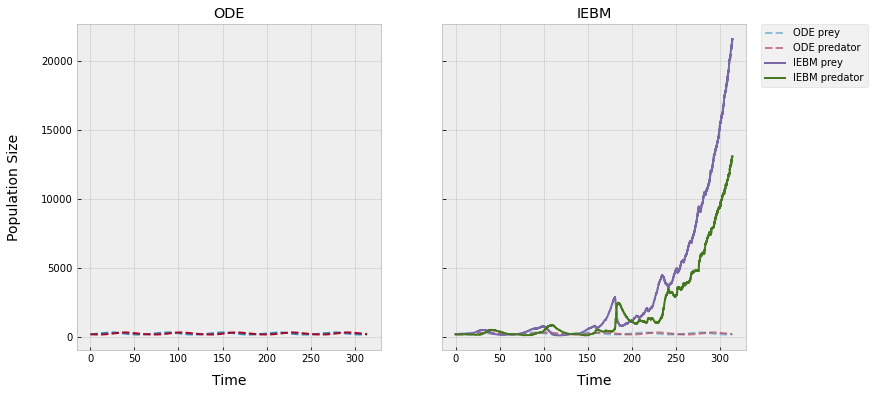

In [28]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax[0].plot(ode_times, ode_prey, label='ODE prey', ls='--')
ax[0].plot(ode_times, ode_pred, label='ODE predator', ls='--')
ax[0].set_title('ODE')
ax[0].set_ylabel('Population Size', labelpad=20, fontsize=14)
ax[0].set_xlabel('Time', labelpad=10, fontsize=14)

ax[1].plot(ode_times, ode_prey, label='ODE prey', ls='--', alpha=0.5)
ax[1].plot(ode_times, ode_pred, label='ODE predator', ls='--', alpha=0.5)
ax[1].plot(patchy_times, patchy_prey, label='IEBM prey')
ax[1].plot(patchy_times, patchy_pred, label='IEBM predator')
ax[1].set_title('IEBM')
ax[1].set_xlabel('Time', labelpad=10, fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.show()